# Vignette 2: MOON

In this vignette, we are going to use MOON (Dugourd et al. in preparation) to iteratively compute enrichment scores for a prior knowledge network, taking metabolic measurements and signalling cascades as inputs. 

In [1]:
import networkcommons as nc
import decoupler as dc
import pandas as pd
import networkx as nx

/home/victo/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


We first import the network, and check it does not contain unsigned interactions or self loops

In [2]:
meta_network = nc.read_network_from_file("../data/moon/meta_network.sif")

In [3]:
len(meta_network.edges()) # the graph representation loses 884 edges, idk why

82673

In [4]:
meta_network = nc.meta_network_cleanup(meta_network)

In [5]:
len(meta_network.edges)

82672

We read inputs:

In [6]:
sig_input = pd.read_csv("../data/moon/cosmos_sig_input.tsv", sep="\t", header=0, index_col=0).value.to_dict()
rna_input = pd.read_csv("../data/moon/cosmos_rna_input.tsv", sep="\t", header=0, index_col=0).value.to_dict()
metab_input = pd.read_csv("../data/moon/cosmos_metab_input.tsv", sep="\t", header=0, index_col=0).value.to_dict()

For the metabolites, we add the compartment it's located

In [7]:
metab_input = nc.prepare_metab_inputs(metab_input, ["c", "m"]) # same as R

Adding compartment codes.


In [8]:
meta_network = nc.filter_pkn_expressed_genes(rna_input.keys(), meta_network)

MOON: removing unexpressed nodes from PKN...


MOON: 13092 nodes removed


We filter out those inputs that cannot be mapped to the prior knowledge network

In [9]:
sig_input = nc.filter_input_nodes_not_in_pkn(sig_input, meta_network) # same as R
meta_network = nc.keep_controllable_neighbours(sig_input, meta_network)  # same as R
metab_input = nc.filter_input_nodes_not_in_pkn(metab_input, meta_network) # Same as R
meta_network = nc.keep_observable_neighbours(metab_input, meta_network)
sig_input = nc.filter_input_nodes_not_in_pkn(sig_input, meta_network) # same as R

COSMOS: 17 input/measured nodes are not inPKN anymore: ['AR', 'CEBPA', 'ESR1', 'FOS', 'FOXA1', 'FOXP1', 'GATA2', 'GATA3', 'HNF4A', 'MITF', 'PRDM14', 'SOX2', 'SPI1', 'TAL1', 'TFAP2C', 'VDR', 'ZNF263']
COSMOS: 154 input/measured nodes are not inPKN anymore: ['Metab__HMDB0011747_c', 'Metab__HMDB0000755_c', 'Metab__HMDB0000355_c', 'Metab__HMDB0000479_c', 'Metab__HMDB0000807_c', 'Metab__HMDB0003464_c', 'Metab__HMDB0000076_c', 'Metab__HMDB0003701_c', 'Metab__HMDB0001494_c', 'Metab__HMDB0000462_c', 'Metab__HMDB0001548_c', 'Metab__HMDB0001893_c', 'Metab__HMDB0000646_c', 'Metab__HMDB0001352_c', 'Metab__HMDB0000902_c', 'Metab__HMDB0000030_c', 'Metab__HMDB0001847_c', 'Metab__HMDB0000062_c', 'Metab__HMDB0000562_c', 'Metab__HMDB0001151_c', 'Metab__HMDB0000283_c', 'Metab__HMDB0000622_c', 'Metab__HMDB0011737_c', 'Metab__HMDB0011741_c', 'Metab__HMDB0000625_c', 'Metab__HMDB0003466_c', 'Metab__HMDB0000130_c', 'Metab__HMDB0000965_c', 'Metab__HMDB0000213_c', 'Metab__HMDB0000715_c', 'Metab__HMDB0004041_c',

In [10]:
len(meta_network.edges) # R is 18715, with n_steps 20

19150

In [11]:
meta_network_compressed, signatures, dup_parents = nc.compress_same_children(meta_network, sig_input, metab_input) # R is 12482

In [12]:
meta_network_compressed = nc.meta_network_cleanup(meta_network_compressed)

In [13]:
len(meta_network_compressed.edges) # R is 12474

12755

Now, the network has been compressed by around a third of its original size, which increases computational efficiency without losing information.
We can get now the GRN from DoRothEA, filtering by levels of confidence A and B.

In [14]:
tf_regn = dc.get_dorothea(levels = ['A', 'B'])
tf_regn.head()

,source,confidence,target,weight
0,MYC,A,TERT,1.0
1,LEF1,A,CCL7,1.0
2,LEF1,A,BIRC5,1.0
3,KLF6,A,LTC4S,1.0
4,KLF5,A,NOTCH1,1.0


Now, we are ready to compute the moon scores on the compressed network, using the signalling network inputs and the metabolic measurements.
The loop will run iteratively until the solution converges (there are no incoherent edges), or a maximum of 10 iterations happen.

In [15]:
before=1
after=0
i=0

while before != after and i < 10:
    before = len(meta_network_compressed.edges)
    moon_res = nc.run_moon_core(sig_input, metab_input, meta_network_compressed, n_layers=20, statistic='wmean')
    meta_network_compressed = nc.filter_incoherent_TF_target(moon_res, tf_regn, meta_network_compressed, rna_input)
    after = len(meta_network_compressed.edges)
    i += 1
    print(f'Attempt {i} - Before: {before}, After: {after}')

Iteration count: 1
Iteration count: 2
Iteration count: 3
Iteration count: 4
Iteration count: 5
Iteration count: 6
Iteration count: 7
Iteration count: 8
Iteration count: 9
Iteration count: 10
Iteration count: 11
Iteration count: 12
Iteration count: 13
Iteration count: 14
Iteration count: 15
Iteration count: 16
Iteration count: 17
Iteration count: 18
Iteration count: 19
Iteration count: 20
Attempt 1 - Before: 12755, After: 12712
Iteration count: 1
Iteration count: 2
Iteration count: 3
Iteration count: 4
Iteration count: 5
Iteration count: 6
Iteration count: 7
Iteration count: 8
Iteration count: 9
Iteration count: 10
Iteration count: 11
Iteration count: 12
Iteration count: 13
Iteration count: 14
Iteration count: 15
Iteration count: 16
Iteration count: 17
Iteration count: 18
Iteration count: 19
Iteration count: 20
Attempt 2 - Before: 12712, After: 12712


Now, we perform the decompression of the network, mapping the compressed nodes to their original components.

In [16]:
decompressed_network = nc.decompress_moon_result(moon_res, signatures, dup_parents, meta_network_compressed)

FInally, we reduce the solution network by removing incoherent edges and filtering for nodes with moon scores higher than 1. We retrieve a networkx.DiGraph that we will visualise, and an attributes dataframe with the moon scores.

In [17]:
res_network, att = nc.reduce_solution_network(decompressed_network, meta_network, 1, sig_input, rna_input)

As an optional step, we can translate the HMDB identifiers to more readable names (e.g HMDB0000122 is Glucose).

In [18]:
mapping_dict = pd.read_csv("../data/moon/hmdb_mapper_vec.tsv", sep="\t", header=0).set_index('hmdb_id')['name'].to_dict()

In [19]:
translated_network, att_translated = nc.translate_res(res_network, att, mapping_dict)

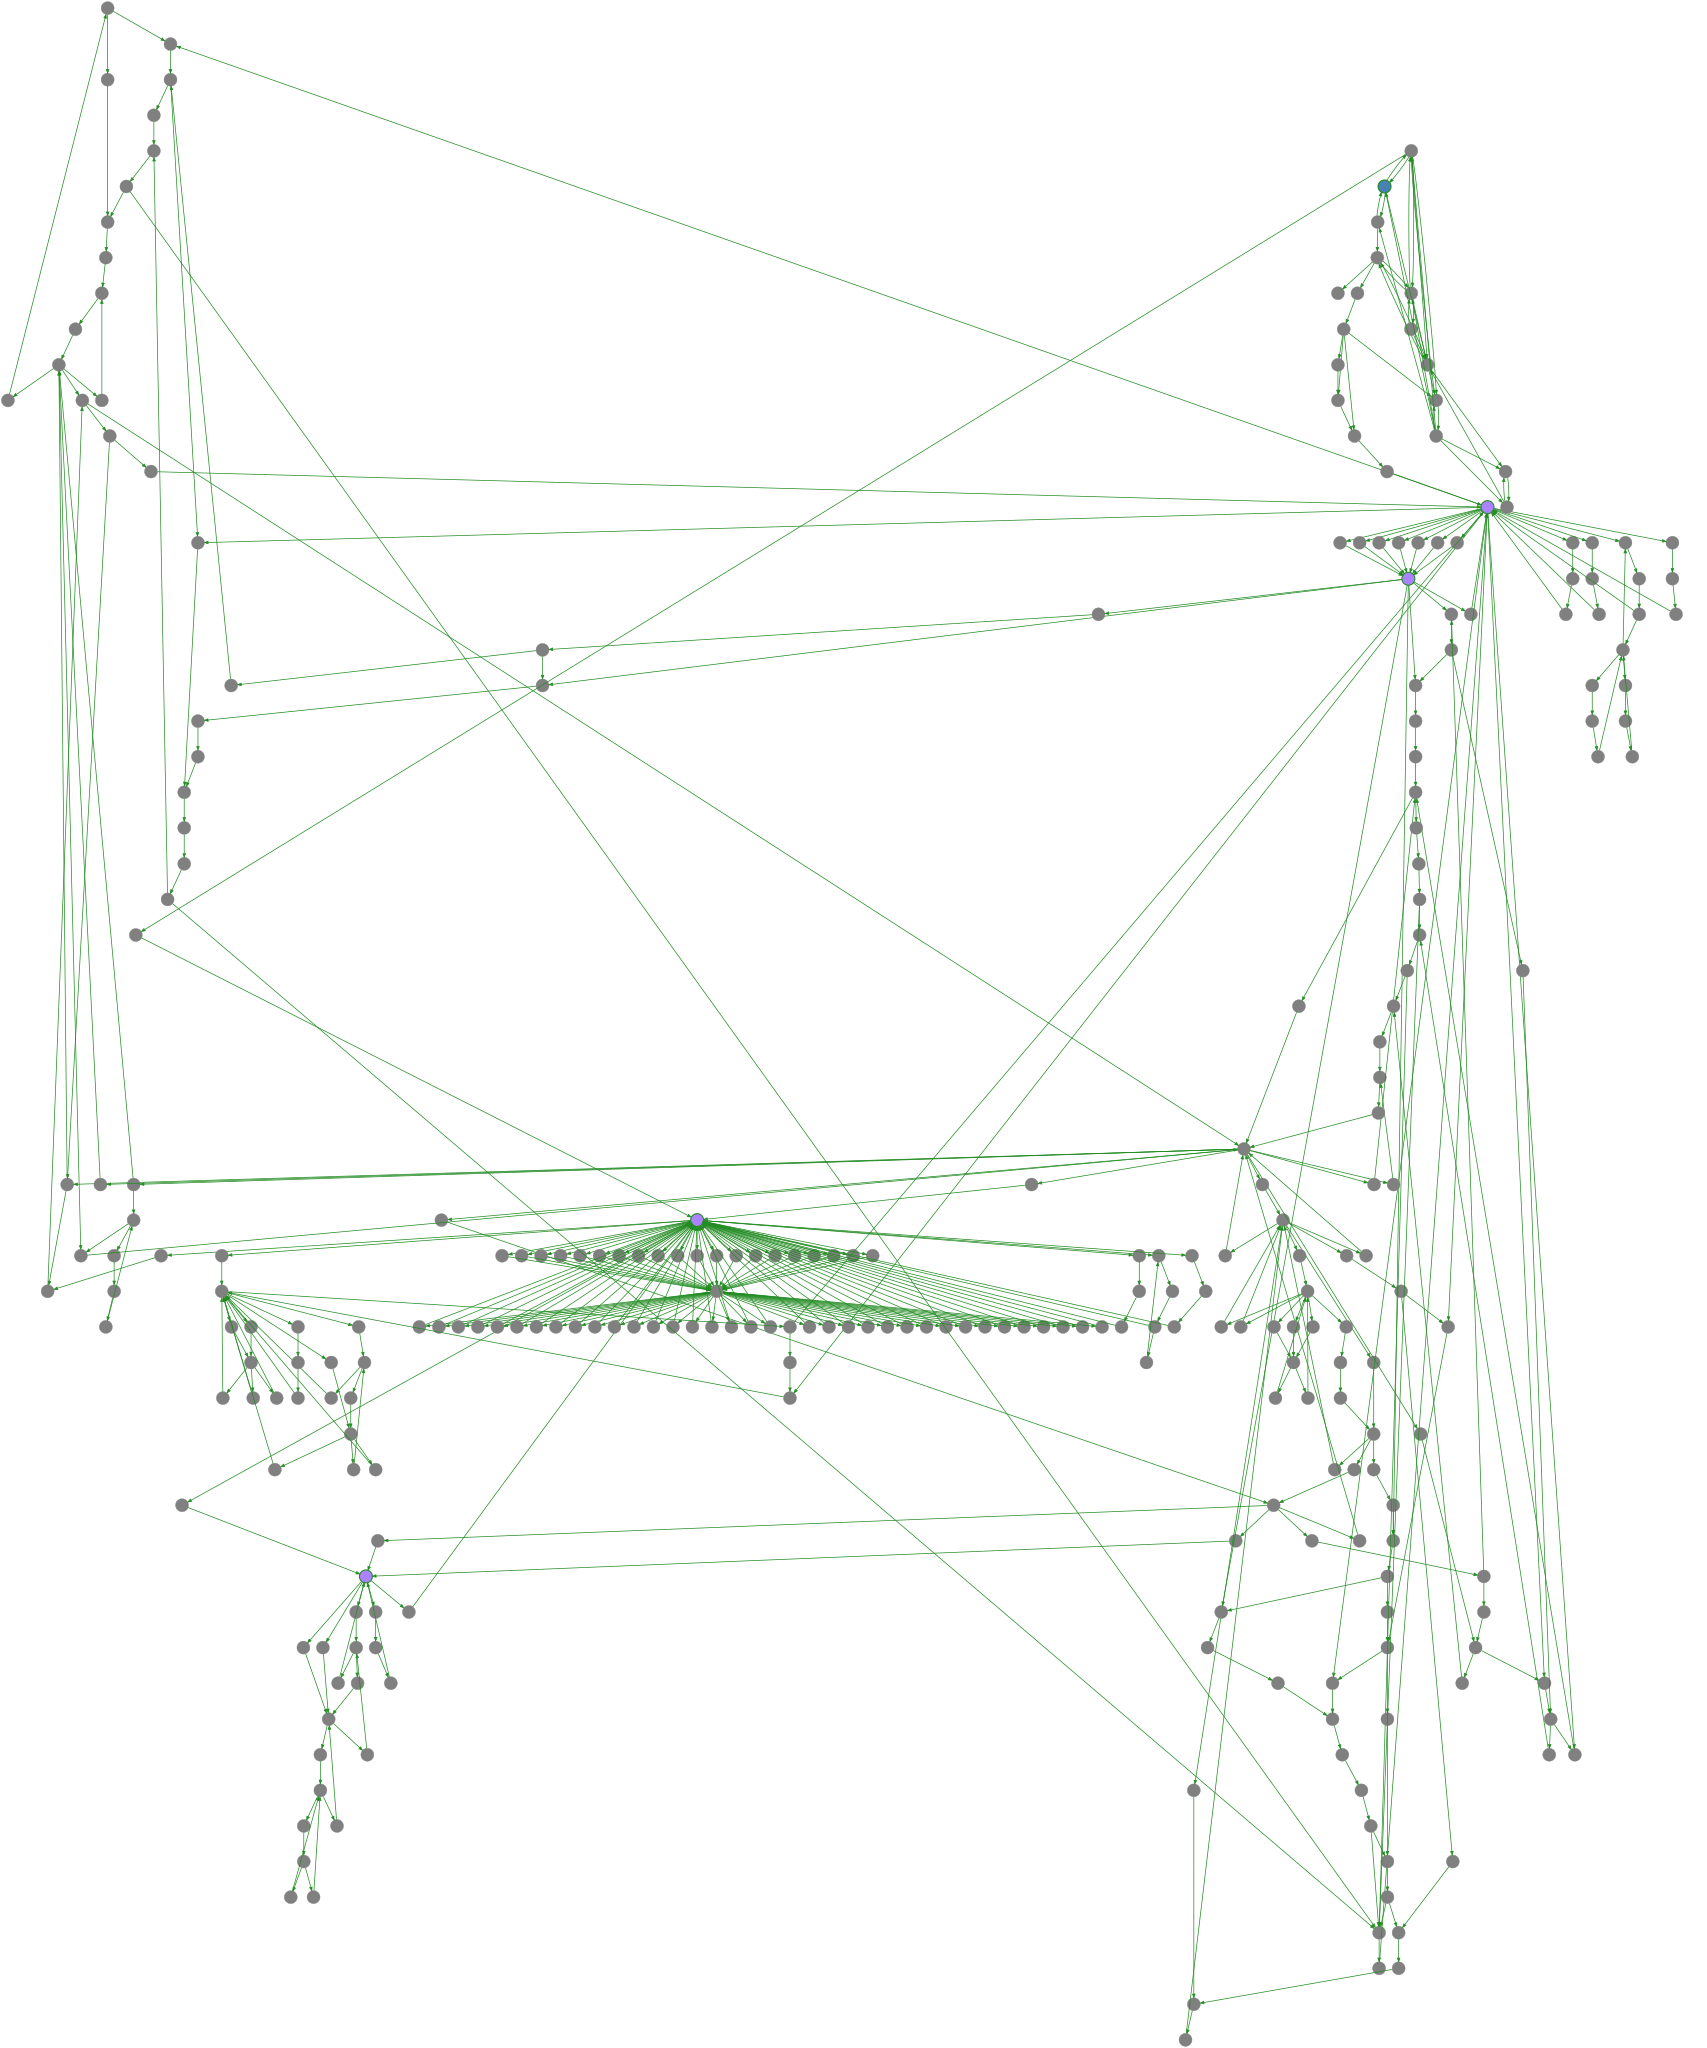

In [22]:
nc.visualize_graph_simple(res_network, sig_input, metab_input)